In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

### Solutions to the Shroedinger equation using the Numerov algorithm

### Useful functions


In [149]:
def find_root_region(fun , a , b , dx = 0.5):
    x1 , x2 = a , b
    while fun(x1)*fun(x2) > 0:
        if abs(fun(x1)) < abs(fun(x2)):
            x1 += dx * (x1 - x2)
        else: x2 += dx * (x2 - x1)
    return x1,x2

def find_root(fun , a , b , tol):
    x1 , x2 = a , b
    root = a
    while abs(fun(root)) > tol:
        root = (x1+x2)/2
        if fun(x1)*fun(root)>0:
            x1 = root
        else: x2 = root
        print(fun(root)) 
    return root

def bis_brack(fun , a , b , tol = 1e-12):
    c,d = find_root_region(fun , a, b)
    root = find_root(fun , c,d,tol)
    return root

In [150]:
def Trapz(func,h):
    integral = func[0]
    integral += func[-1]
    for i in range(1,len(func)-1):
        integral += 2* func[i]
    return integral * (h/2)

In [151]:
def newt_raph(func , x_i , tol=1e-12):
    x_n = x_i + 5*tol
    x_nn = x_n - func(x_n) * (x_n - x_i) / (func(x_n) - func(x_i))
    while abs(x_nn - x_n) > tol:
        der =(func(x_nn) - func(x_n)) /  (x_nn - x_n) 
        x_n = x_nn
        x_nn = x_nn - func(x_nn) / der
        print(func(x_nn))
    return x_nn

### Example of bisection and bracketing

In [8]:
fun = lambda x: np.sin(x)
a , b = 3,5 
bis_brack(fun , a , b) 

3.1415926535901235

## Numerov

### Infinite square potential well

In [32]:
def numerov_forward(E , potential = lambda x:0*x,
           boundaries = [0,10], boundary_cond = [0,0], mesh_size = 1000):
    # general params
    dphi_dx = 0.1
    # spatial coord
    xs = np.linspace(boundaries[0] , boundaries[-1], mesh_size)
    dx = np.mean(np.diff(xs))
    # potential
    V = potential(xs)
    # phi initialization
    phi = np.zeros(mesh_size)
    phi[0] = boundary_cond[0]
    phi[1] = phi[0] + dphi_dx * dx
    # solver num
    i = 1
    while i <= (mesh_size - 2):
        wiii = (1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2 * (1 - 5*dx**2/6 * (E - V[i]))
        wi = - ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi[i+1] = 1/wiii * (wii * phi[i] + wi * phi[i-1])
        i+=1
    return (phi[-1] - boundary_cond[-1])

def numerov_forward_solver(init_guesses = [0,1], potential = lambda x: 0 * x,
                           boundaries = [0,10] , boundary_cond = [0,0] , mesh_size = 1000,
                          solver = 'BB'):
    # general params
    tol = 1e-5
    dphi_dx = 0.1
    # eigenvalue finder
    NUM = partial(numerov_forward , potential = potential , 
                  boundaries = boundaries , boundary_cond = boundary_cond , mesh_size = mesh_size)
    if solver == 'BB':
        E = bis_brack(NUM , init_guesses[0] , init_guesses[-1] , tol = tol)
    elif solver == 'NR':
        E = newt_raph(NUM , init_guesses[0] , tol = tol)
    # spatial coord
    xs = np.linspace(boundaries[0] , boundaries[-1], mesh_size)
    dx = np.mean(np.diff(xs))
    # potential
    V = potential(xs)
    # phi initialization
    phi = np.zeros(mesh_size)
    phi[0] = boundary_cond[0]
    phi[1] = phi[0] + dphi_dx * dx
    # solver
    i = 1
    while i <= (mesh_size - 2):
        wiii = (1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2 * (1 - 5*dx**2/6 * (E - V[i]))
        wi = - ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi[i+1] = 1/wiii * (wii * phi[i] + wi * phi[i-1])
        i+=1
    norm = Trapz(abs(phi)**2 , dx)
    return xs , phi/np.sqrt(norm) , E

In [120]:
potential = lambda x : 0 * x
boundaries = [0,1]
boundary_cond = [0,0]
mesh_size = 300
solver = 'NR'


L = boundaries[-1] - boundaries[0]
Theor_energies = np.array( [1/2*(np.pi * n /L)**2 for n in range(1,10)])
Theor_energies


E_diff = []
fun_mses = []
for n in range(len(Theor_energies)):
    en = Theor_energies[n]
    init_guesses = [en-0.5,en+0.5]
    xs , phi , E = numerov_forward_solver(init_guesses , potential , 
                                          boundaries , boundary_cond , mesh_size , 
                                         solver)
    fun_mses.append(np.mean( (phi - np.sqrt(2/L) * np.sin(np.pi * (n+1) * xs / L))**2))
    E_diff.append(E - en)
E_diff = np.array(E_diff)
MSE_E = np.mean(E_diff**2)
fun_mses = np.array(fun_mses)
MSE_fun = np.mean(fun_mses)
MSE_E , MSE_fun , E_diff

(2.565470215849629e-09,
 8.755586236279887e-24,
 array([-2.51172416e-10, -1.60456963e-08, -1.82689440e-07, -1.02669560e-06,
        -3.91601307e-06, -1.16936384e-05, -2.94886382e-05, -6.57105070e-05,
        -1.33223937e-04]))

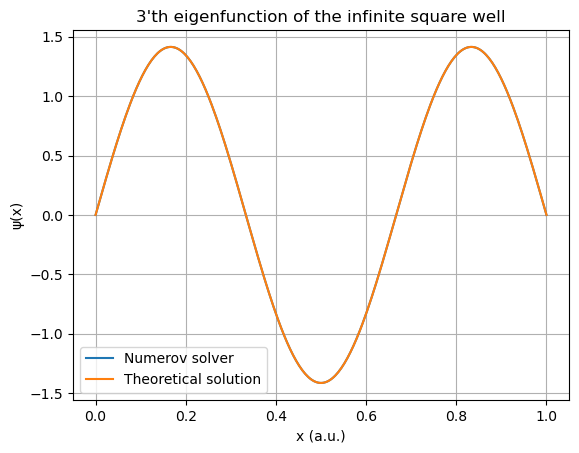

(44.41321962221267, 44.41321980490211, 0.9999999999999994)

In [126]:
n=2
en = Theor_energies[n]
init_guesses = [en-0.5,en+0.5]
xs , phi , E = numerov_forward_solver(init_guesses , potential , 
                                      boundaries , boundary_cond , mesh_size , 
                                      solver)
plt.plot(xs , phi , label = 'Numerov solver')
plt.plot(xs , np.sqrt(2/L) * np.sin(np.pi * (n+1) * xs / L) , label = 'Theoretical solution')
plt.legend()
plt.xlabel('x (a.u.)')
plt.ylabel('ψ(x)')
plt.grid()
plt.title(f"{n+1}'th eigenfunction of the infinite square well")
plt.show()
E , Theor_energies[n] , Trapz(abs(phi)**2,np.mean(np.diff(xs)))

### Finite potential problems

In [182]:
def numerov_back_for(E , potential = lambda x:0*x, matching_point = 1.2,
           boundaries = [0,10], boundary_cond = [0,0], mesh_size = 1000):
    # general params
    dphi_dx = 0.1
    # spatial coord
    xs = np.linspace(boundaries[0] , boundaries[-1], mesh_size)
    dx = np.mean(np.diff(xs))
    # potential
    V = potential(xs)
    # phi initialization
    phi_L = np.zeros(mesh_size)
    phi_R = np.zeros(mesh_size)
    phi_L[0] = boundary_cond[0]
    phi_R[-1] = boundary_cond[-1]
    phi_L[1] = phi_L[0] + dphi_dx * dx
    phi_R[-2] = phi_R[-1] - dphi_dx * dx
    # matching point
    split_index = np.argmin(abs(xs-matching_point))
    # solver num
    maximum = 0.0
    # forward integration
    i = 1
    while i <= split_index : # go to matching point + dx
        wiii = (1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2 * (1 - 5*dx**2/6 * (E - V[i]))
        wi = - ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi_L[i+1] = 1/wiii * (wii * phi_L[i] + wi * phi_L[i-1])
        if abs(phi_L[i+1]) > maximum: maximum = abs(phi_L[i+1])
        if phi_L[i+1] > 1e6:
            phi_L *= 1e-6
            maximum *= 1e-6
        i+=1
    # backward integration
    i = mesh_size - 2
    while i >= split_index: # go to matching point - dx
        wiii = -(1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2*(1 - 5*dx**2/6 * (E - V[i]))
        wi = ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi_R[i-1] = 1/wi * (wii * phi_R[i] + wiii * phi_R[i+1])
        if abs(phi_R[i-1]) > maximum: maximum = abs(phi_R[i-1])
        if phi_R[i-1] > 1e6:
            phi_R *= 1e-6
            maximum *= 1e-6
        i-=1
    # Rescaling
    rescaling_par = phi_R[split_index] / phi_L[split_index]
    phi_L *= rescaling_par
    
    derL = ( phi_L[split_index + 1] - phi_L[split_index - 1]) / (2*dx)
    derR = ( phi_R[split_index + 1] - phi_R[split_index - 1]) / (2*dx)
    
    return (derL - derR) / maximum

def numerov_back_for_solver(init_guesses = [0,1], potential = lambda x: 0 * x, matching_point = 1.2,
                           boundaries = [0,10] , boundary_cond = [0,0] , mesh_size = 1000,
                          solver = 'BB'):
    # general params
    tol = 1e-5
    dphi_dx = 0.1
    # eigenvalue finder
    NUM = partial(numerov_back_for , potential = potential , 
                  boundaries = boundaries , boundary_cond = boundary_cond , mesh_size = mesh_size)
    if solver == 'BB':
        E = bis_brack(NUM , init_guesses[0] , init_guesses[-1] , tol = tol)
    elif solver == 'NR':
        E = newt_raph(NUM , init_guesses[0] , tol = tol)
    print('found eigenvalue')
    # spatial coord
    xs = np.linspace(boundaries[0] , boundaries[-1], mesh_size)
    dx = np.mean(np.diff(xs))
    # matching point
    split_index = np.argmin(abs(xs-matching_point))
    # potential
    V = potential(xs)
    # phi initialization
    phi_L = np.zeros(mesh_size)
    phi_R = np.zeros(mesh_size)
    phi_L[0] = boundary_cond[0]
    phi_R[-1] = boundary_cond[-1]
    phi_L[1] = phi_L[0] + dphi_dx * dx
    phi_R[-2] = phi_R[-1] - dphi_dx * dx
    # solver
    # forward integration
    i = 1
    while i <= split_index : # go to matching point + dx
        wiii = (1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2 * (1 - 5*dx**2/6 * (E - V[i]))
        wi = - ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi_L[i+1] = 1/wiii * (wii * phi_L[i] + wi * phi_L[i-1])
        if phi_L[i+1] > 1e6:
            phi_L *= 1e-6
        i+=1
    # backward integration
    i = mesh_size - 2
    while i >= split_index: # go to matching point - dx
        wiii = -(1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2*(1 - 5*dx**2/6 * (E - V[i]))
        wi = ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi_R[i-1] = 1/wi * (wii * phi_R[i] + wiii * phi_R[i+1])
        if phi_R[i-1] > 1e6:
            phi_R *= 1e-6
        i-=1
    # Rescaling
    rescaling_par = phi_R[split_index] / phi_L[split_index]
    phi_L *= rescaling_par   
    phi_L[split_index-1:split_index+2] = np.array([0,0,0])
    phi = phi_L + phi_R

    norm = Trapz(abs(phi)**2 , dx)
    return xs , phi/np.sqrt(norm) , E

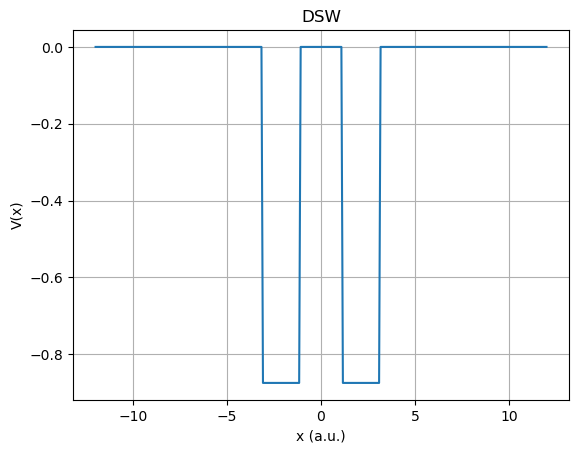

In [383]:
d = 2.26
potential = lambda x :np.where((x>-2-d/2) & (x<-d/2) | (x>d/2) & (x<2+d/2), -0.875 , 0)
boundaries = [-12,12]
boundary_cond = [0,0]
mesh_size = 300
init_guesses = [0.46 , 0.55]
matching_point = 0.9
solver = 'BB'

# potential plotting
X = np.linspace(boundaries[0] , boundaries[-1] , mesh_size)
plt.plot(X , potential(X))
plt.grid()
plt.xlabel('x (a.u.)')
plt.ylabel('V(x)')
plt.title('DSW')
plt.show()

In [386]:
Es = []
phis = []
for n in [0.1,-0.1]:
    init_guesses = [-0.50 - (n+0.1) , -0.50 - (n-0.1)]
    xs , phi , E = numerov_back_for_solver(init_guesses , potential , matching_point,
                                       boundaries , boundary_cond , mesh_size , 
                                       solver)
    phis.append(phi)
    Es.append(E)

-0.14153150695521577
0.19937849752720438
-0.10896007226823802
0.03401077609249543
0.36675082304797346
0.0011258905399855865
-0.07498593441512379
-0.04109521648447871
-0.020704894103179602
-0.009991788173520958
-0.004486704506860488
-0.0016942732674403247
-0.00028771333483302203
0.00041820105604577386
6.502286144262344e-05
-0.0001114003759376419
-2.320255575307145e-05
2.0906701519517697e-05
-1.1487899469314786e-06
found eigenvalue
0.20735037979907317
0.17007284515104706
0.07338219198675268
-0.08256613901602355
0.00745509054041988
-0.03305547444128517
-0.01193267274977732
-0.0020457638691701945
0.0027503175731865893
0.00036400082852900523
-0.0008379104739837895
-0.0002362171250811523
6.407564829879652e-05
-8.602471106599312e-05
-1.096303457246386e-05
2.6559180105036067e-05
7.798791408201972e-06
found eigenvalue


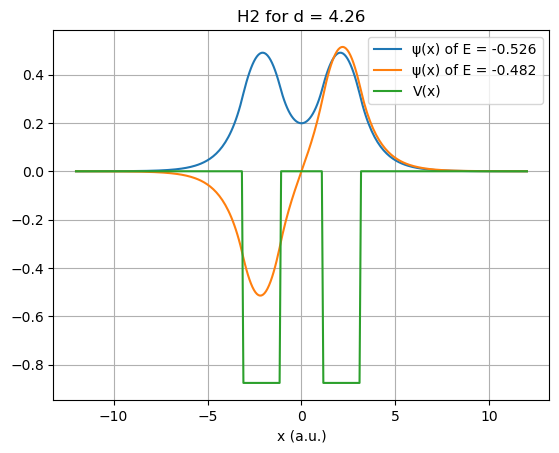

In [387]:
for n in range(2):
    plt.plot(xs , -phis[n] , label = f'ψ(x) of E = {Es[n]:.3f}')
X = np.linspace(boundaries[0] , boundaries[-1] , mesh_size)
plt.plot(X , potential(X) , label = 'V(x)')
plt.legend()
plt.xlabel('x (a.u.)')
plt.ylabel('')
plt.grid()
plt.title(f"H2 for d = {2+d}")
plt.show()

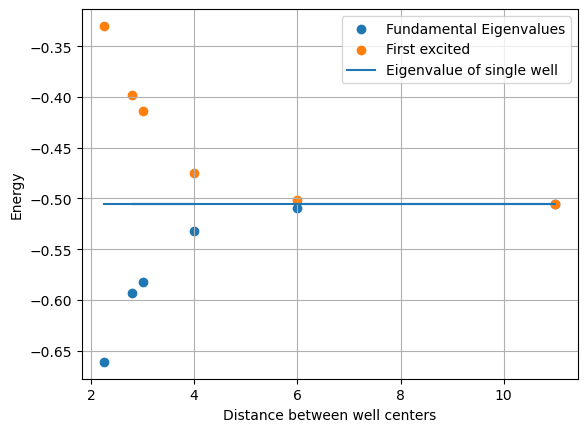

In [381]:
# kept them written down

even = [-0.330 , -0.475 ,-0.414, -0.398, -0.505 , -0.501]
odd = [-0.661, -0.532 , -0.582 , -0.593, - 0.505 , -0.509]
D = [2.26 , 4 ,3 ,2.8,11,6]

plt.scatter(D , odd , label = 'Fundamental Eigenvalues')
plt.scatter(D , even , label = 'First excited')
plt.plot(D , [-0.505]*len(D) , label = 'Eigenvalue of single well')
plt.grid()
plt.xlabel('Distance between well centers')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Hydrogen

In [464]:
def numerov_backward(E , potential = lambda x:0*x,
           boundaries = [0,10], boundary_cond = [0,0], mesh_size = 1000):
    # general params
    dphi_dx = -0.1
    # spatial coord
    xs = np.linspace(boundaries[0] , boundaries[-1], mesh_size)
    dx = np.mean(np.diff(xs))
    # potential
    V = potential(xs)
    # phi initialization
    phi = np.zeros(mesh_size)
    phi[-1] = boundary_cond[-1]
    phi[-2] = phi[-1] - dphi_dx * dx
    # solver num
    i = mesh_size - 2
    while i >= 2: # go to matching point - dx
        wiii = -(1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2*(1 - 5*dx**2/6 * (E - V[i]))
        wi = ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi[i-1] = 1/wi * (wii * phi[i] + wiii * phi[i+1])
        if phi[i-1] > 1e6:
            phi *= 1e-6
        i-=1
    return phi[1] - (phi[2] - phi[1]) * xs[1] / dx

def numerov_backward_solver(init_guesses = [0,1], potential = lambda x: 0 * x,
                           boundaries = [0,10] , boundary_cond = [0,0] , mesh_size = 1000,
                          solver = 'BB'):
    # general params
    tol = 1e-10
    dphi_dx = -0.1
    # eigenvalue finder
    NUM = partial(numerov_backward , potential = potential , 
                  boundaries = boundaries , boundary_cond = boundary_cond , mesh_size = mesh_size)
    if solver == 'BB':
        E = bis_brack(NUM , init_guesses[0] , init_guesses[-1] , tol = tol)
    elif solver == 'NR':
        E = newt_raph(NUM , init_guesses[0] , tol = tol)
    print('Eigenvalue found')
    # spatial coord
    xs = np.linspace(boundaries[0] , boundaries[-1], mesh_size)
    dx = np.mean(np.diff(xs))
    # potential
    V = np.concatenate(([0.0],potential(xs[1:])))
    # phi initialization
    phi = np.zeros(mesh_size)
    phi[-1] = boundary_cond[-1]
    phi[-2] = phi[-1] - dphi_dx * dx
    # solver num
    i = mesh_size - 2
    while i >= 2: # go to matching point - dx
        wiii = -(1 + dx**2 / 6 * (E - V[i+1]))
        wii = 2*(1 - 5*dx**2/6 * (E - V[i]))
        wi = ( 1 + dx**2 / 6 * (E - V[i-1]) )
        phi[i-1] = 1/wi * (wii * phi[i] + wiii * phi[i+1])
        if phi[i-1] > 1e6:
            phi *= 1e-6
        i-=1
    phi[0] = phi[1] - (phi[2] - phi[1]) * xs[1] / dx
    norm = Trapz(abs(phi)**2 , dx)
    return xs , phi/np.sqrt(norm) , E

0.012984468722445186
0.0005045897610020944
3.9329921364128495e-06
1.205444633001207e-09
8.668621376273222e-13
Eigenvalue found
-0.32347784793864776
-0.001045939091454784
-1.9237995729781687e-07
-1.5943442122079432e-09
Eigenvalue found
-0.0001662296208502223
-3.05023416524719e-07
2.4106272533686024e-11
1.5480949855373183e-12
Eigenvalue found


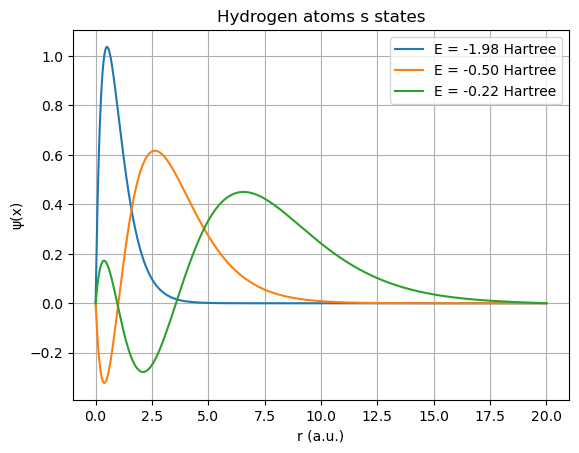

In [467]:
l = 0
Z = 1
potential = lambda x : l*(l+1)/(x+1e-10)**2 - 2*Z/(x+1e-10)
boundaries = [0,20]
boundary_cond = [0,0]
mesh_size = 1000
solver = 'NR'


for init_guesses in [ [-2,-1.9] , [-.5,0.49] , [-.22 , -0.2]  ]:
    xs , phi , E = numerov_backward_solver(init_guesses , potential , 
                                      boundaries , boundary_cond , mesh_size , 
                                      solver)
    plt.plot(xs,phi , label = f'E = {E:.2f} Hartree')
plt.ylabel('ψ(x)')
plt.xlabel('r (a.u.)')
plt.legend()
plt.title('Hydrogen atoms s states')
plt.grid()
plt.show()

### Matrix reduction

In [468]:
from numpy import linalg as LA
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as splin
from scipy.sparse import csr_matrix

def discretization_shrodinger(mesh_size,V_fun,boundaries):
    
    xs = np.linspace(boundaries[0] , boundaries[-1] , mesh_size)
    dx = np.mean(np.diff(xs))
    
    V = V_fun(xs)
    V = V[1:-1]
    
    dim = len(V)
    w = -2*(1+V*dx**2)
    W = np.array([np.array([w[i] if i == j else (1 if abs(i - j) == 1 else 0) for i in range(dim)]) for j in range(dim)])

    W = csr_matrix(W)
    
    eigenvalues, eigenstates = spla.eigsh(W , k = 10 , which = 'SM')
    E = -0.5*eigenvalues/dx**2

    new_eigenstates = np.zeros((mesh_size, 10))  # mesh_size instead of dim+2
    new_eigenstates[1:-1, :] = eigenstates
    
    return E , new_eigenstates , xs

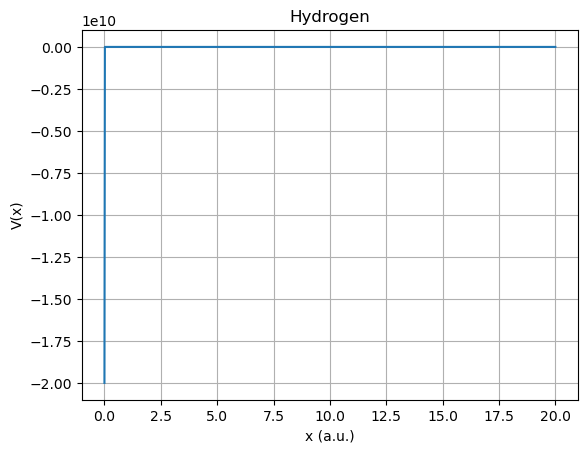

In [551]:
V = lambda x:  - 2*Z/(x + 1e-10)
plt.plot(xs,V(xs))
plt.grid()
plt.xlabel('x (a.u.)')
plt.ylabel('V(x)')
plt.title('Hydrogen')
plt.show()

In [547]:
E , eigenstates , xs = discretization_shrodinger(1000 , V , [0,20])
E , eigenstates[:,-1].shape

(array([ 1.0272453 ,  0.78051277,  0.56009698,  0.36645884,  0.2002878 ,
         0.06271294, -0.04423465, -0.12220365, -0.22220704, -0.49994991]),
 (1000,))

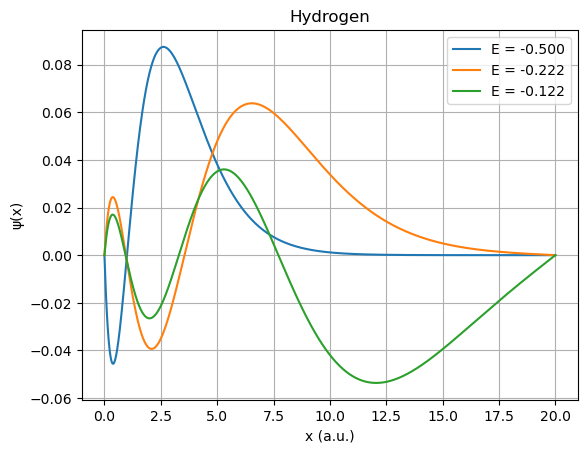

In [550]:
for i in range(1,4):
    plt.plot(xs , eigenstates[:,-i] , label = f'E = {E[-i]:.3f}')
plt.ylabel('ψ(x)')
plt.xlabel('x (a.u.)')
plt.legend()
plt.title(f'Hydrogen')
plt.grid()
plt.show()

### EOF